In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow.compat.v1.keras
import tensorflow.compat.v1.keras.backend as K
from tensorflow.compat.v1.keras.layers import LSTM,Dropout,Dense,TimeDistributed,Conv1D,MaxPooling1D,Flatten
from tensorflow.compat.v1.keras.models import Sequential

# from keras.backend.tensorflow_backend import set_session



# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
import gc
from numba import jit
from IPython.display import display, clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
sns.set_style("whitegrid")

W0526 04:48:15.618455 140633457342208 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/compat/v2_compat.py:63: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


### 1. Load Data

In [2]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np

In [3]:
%%time 
train_set = pq.read_pandas('input/train.parquet').to_pandas()

CPU times: user 2min 4s, sys: 2min 30s, total: 4min 35s
Wall time: 17 s


In [4]:
%%time
meta_train = pd.read_csv('input/metadata_train.csv')

CPU times: user 5.01 ms, sys: 8.41 ms, total: 13.4 ms
Wall time: 12.2 ms


### 2. Process and Minimize Data

In [5]:
@jit('float32(float32[:,:], int32)')
def feature_extractor(x, n_part=1000):
    lenght = len(x)
    pool = np.int32(np.ceil(lenght/n_part))
    output = np.zeros((n_part,))
    for j, i in enumerate(range(0,lenght, pool)):
        if i+pool < lenght:
            k = x[i:i+pool]
        else:
            k = x[i:]
        output[j] = np.max(k, axis=0) - np.min(k, axis=0)
    return output

In [6]:
x_train = []
y_train = []
for i in tqdm(meta_train.signal_id):
    idx = meta_train.loc[meta_train.signal_id==i, 'signal_id'].values.tolist()
    y_train.append(meta_train.loc[meta_train.signal_id==i, 'target'].values)
    x_train.append(abs(feature_extractor(train_set.iloc[:, idx].values, n_part=400)))

100%|██████████| 8712/8712 [01:44<00:00, 73.36it/s] 


In [7]:
del train_set; gc.collect()

24360

In [8]:
y_train = np.array(y_train).reshape(-1,)
X_train = np.array(x_train).reshape(-1,x_train[0].shape[0])

In [9]:
print('y_train', y_train.shape)
print('X_train', X_train.shape)

y_train (8712,)
X_train (8712, 400)


### 3. Build Primitive CNN + LSTM Model

In [10]:
def keras_auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [11]:
#So far each instance is one signal. We will diversify them in next step
n_signals = 1
#Binary Classification
n_outputs = 1 

In [12]:
#Build the model
verbose, epochs, batch_size = True, 15, 16
n_steps, n_length = 40, 10
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_signals))
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_signals)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid'))

W0526 04:50:19.037246 140633457342208 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1257: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [13]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras_auc])

W0526 04:50:19.571294 140633457342208 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/metrics_impl.py:526: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0526 04:50:19.616733 140633457342208 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/metrics_impl.py:788: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [14]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/15
8712/8712 [==============================] - 45s 5ms/sample - loss: 0.2240 - keras_auc: 0.5723
Epoch 2/15
8712/8712 [==============================] - 44s 5ms/sample - loss: 0.1868 - keras_auc: 0.6818
Epoch 3/15
8712/8712 [==============================] - 43s 5ms/sample - loss: 0.1539 - keras_auc: 0.7678
Epoch 4/15
8712/8712 [==============================] - 43s 5ms/sample - loss: 0.1409 - keras_auc: 0.8156
Epoch 5/15
8712/8712 [==============================] - 43s 5ms/sample - loss: 0.1285 - keras_auc: 0.8468
Epoch 6/15
8712/8712 [==============================] - 43s 5ms/sample - loss: 0.1235 - keras_auc: 0.8672
Epoch 7/15
8712/8712 [==============================] - 44s 5ms/sample - loss: 0.1248 - keras_auc: 0.8805
Epoch 8/15
8712/8712 [==============================] - 44s 5ms/sample - loss: 0.1215 - keras_auc: 0.8892
Epoch 9/15
8712/8712 [==============================] - 44s 5ms/sample - loss: 0.1170 - keras_auc: 0.8970
Epoch 10/15
8712/8712 [=======================

In [15]:
model.save_weights('model1.hdf5')

### Further processing of Signals to Diversify the Model
Proposed data structure: n_instances x n_timesteps x n_channels

In [16]:
#Both numpy and scipy has utilities for FFT which is an endlessly useful algorithm
from numpy.fft import *
from scipy import fftpack

In [17]:
%%time 
train_set = pq.read_pandas('input/train.parquet').to_pandas()

CPU times: user 1min 28s, sys: 59.6 s, total: 2min 28s
Wall time: 7.54 s


In [18]:
#FFT to filter out HF components and get main signal profile
def low_pass(s, threshold=1e4):
    fourier = rfft(s)
    frequencies = rfftfreq(s.size, d=2e-2/s.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

In [19]:
def phase_indices(signal_num):
    phase1 = 3*signal_num
    phase2 = 3*signal_num + 1
    phase3 = 3*signal_num + 2
    return phase1,phase2,phase3

In [20]:
s_id = 14
p1,p2,p3 = phase_indices(s_id)

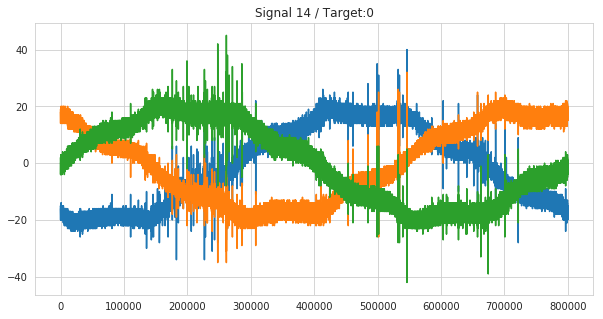

In [21]:
plt.figure(figsize=(10,5))
plt.title('Signal %d / Target:%d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(train_set.iloc[:,p1])
plt.plot(train_set.iloc[:,p2])
plt.plot(train_set.iloc[:,p3])

In [22]:
lf_signal_1 = low_pass(train_set.iloc[:,p1])
lf_signal_2 = low_pass(train_set.iloc[:,p2])
lf_signal_3 = low_pass(train_set.iloc[:,p3])

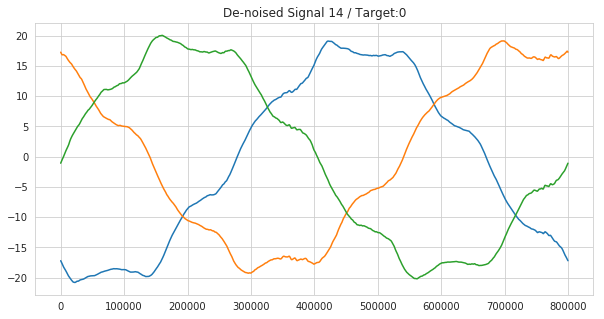

In [23]:
plt.figure(figsize=(10,5))
plt.title('De-noised Signal %d / Target:%d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(lf_signal_1)
plt.plot(lf_signal_2)
plt.plot(lf_signal_3)

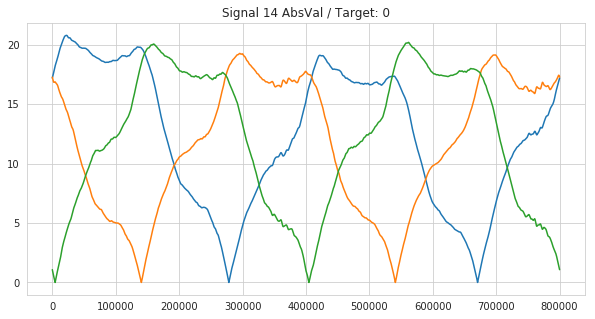

In [24]:
plt.figure(figsize=(10,5))
plt.title('Signal %d AbsVal / Target: %d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(np.abs(lf_signal_1))
plt.plot(np.abs(lf_signal_2))
plt.plot(np.abs(lf_signal_3))

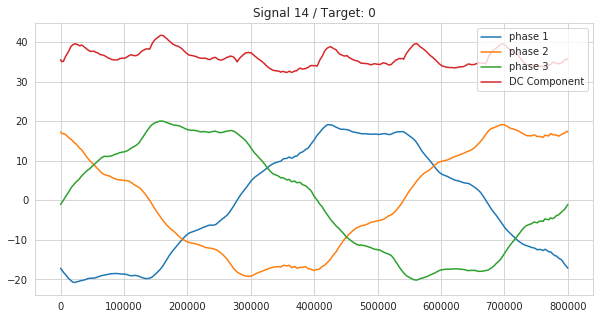

In [25]:
plt.figure(figsize=(10,5))
plt.title('Signal %d / Target: %d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(lf_signal_1)
plt.plot(lf_signal_2)
plt.plot(lf_signal_3)
plt.plot((np.abs(lf_signal_1)+np.abs(lf_signal_2)+np.abs(lf_signal_3)))
plt.legend(['phase 1','phase 2','phase 3','DC Component'],loc=1)

In [26]:
###Filter out low frequencies from the signal to get HF characteristics
def high_pass(s, threshold=1e7):
    fourier = rfft(s)
    frequencies = rfftfreq(s.size, d=2e-2/s.size)
    fourier[frequencies < threshold] = 0
    return irfft(fourier)

In [27]:
hf_signal_1 = high_pass(train_set.iloc[:,p1])
hf_signal_2 = high_pass(train_set.iloc[:,p2])
hf_signal_3 = high_pass(train_set.iloc[:,p3])

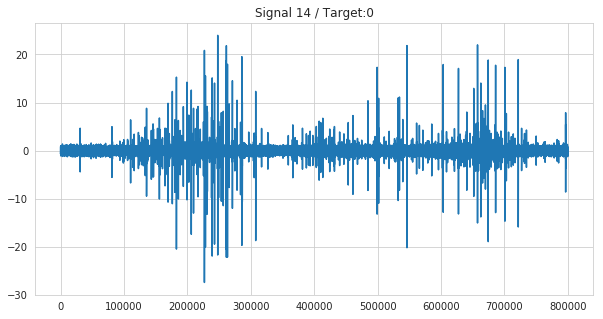

In [28]:
plt.figure(figsize=(10,5))
plt.title('Signal %d / Target:%d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(hf_signal_1)

In [29]:
signal = train_set.iloc[:,p1]

In [30]:
%%time
x = signal
X = fftpack.fft(x,n=400)
freqs = fftpack.fftfreq(n=400,d=2e-2/x.size)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3 ms


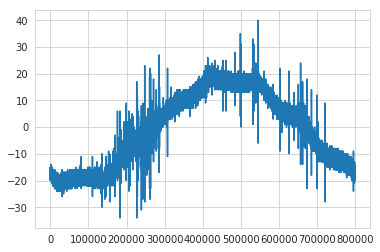

In [31]:
plt.plot(x)

<StemContainer object of 3 artists>

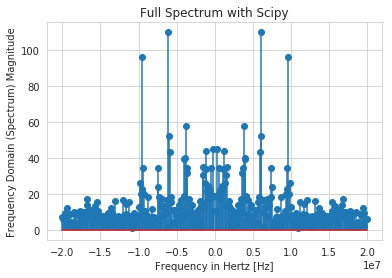

In [32]:
fig, ax = plt.subplots()
ax.set_title('Full Spectrum with Scipy')
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.stem(freqs[1:], np.abs(X)[1:])

In [33]:
%%time
x = high_pass(train_set.iloc[:,p1])
X = fftpack.fft(x,n=400)
freqs = fftpack.fftfreq(n=400,d=2e-2/x.size) 

CPU times: user 56.9 ms, sys: 20.6 ms, total: 77.5 ms
Wall time: 75.7 ms


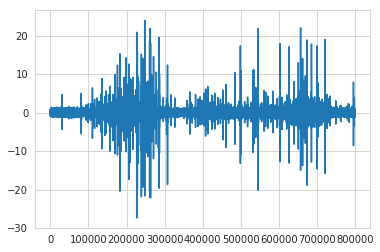

In [34]:
plt.plot(x)

<StemContainer object of 3 artists>

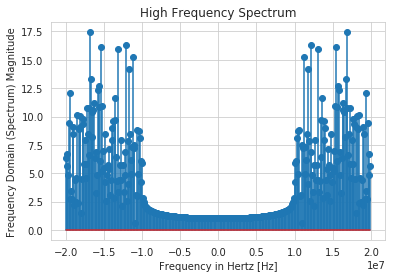

In [35]:
fig, ax = plt.subplots()
ax.set_title('High Frequency Spectrum')
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.stem(freqs[1:], np.abs(X)[1:])

In [36]:
%%time
x = low_pass(signal)
X = fftpack.fft(x,n=400)
freqs = fftpack.fftfreq(n=400,d=2e-2/x.size) 

CPU times: user 25.2 ms, sys: 46 ms, total: 71.2 ms
Wall time: 93.5 ms


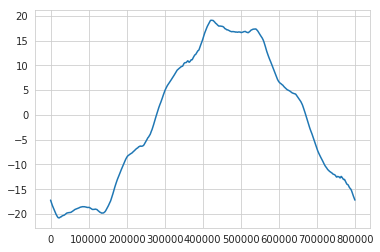

In [37]:
plt.plot(x)

<StemContainer object of 3 artists>

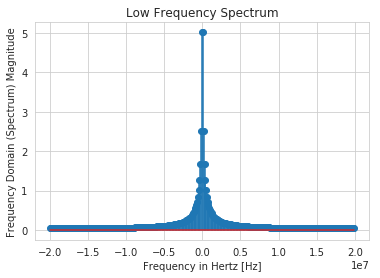

In [38]:
fig, ax = plt.subplots()
ax.set_title('Low Frequency Spectrum')
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.stem(freqs[1:], np.abs(X)[1:])

In [39]:
p1,p2,p3 = phase_indices(100)
signal = train_set.iloc[:,p1]

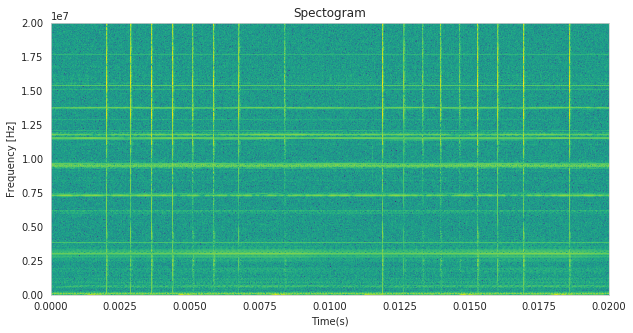

In [40]:
from scipy import signal as sgn
M = 1024
rate = 1/(2e-2/signal.size)

freqs, times, Sx = sgn.spectrogram(signal.values, fs=rate, window='hanning',
                                      nperseg=1024, noverlap=M - 100,
                                      detrend='constant', scaling='spectrum')

f, ax = plt.subplots(figsize=(10, 5))
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time(s)')
ax.set_title('Spectogram')
ax.pcolormesh(times, freqs, np.log10(Sx), cmap='viridis')

### 5. Add Features

In [41]:
x_train_lp = []
x_train_hp = []
x_train_dc = []
for i in meta_train.signal_id:
    idx = meta_train.loc[meta_train.signal_id==i, 'signal_id'].values.tolist()
    clear_output(wait=True)
    display(idx)
    hp = high_pass(train_set.iloc[:, idx[0]])
    lp = low_pass(train_set.iloc[:, idx[0]])
    meas_id = meta_train.id_measurement[meta_train.signal_id==idx].values[0]
    p1,p2,p3=phase_indices(meas_id)
    lf_signal_1,lf_signal_2,lf_signal_3 = low_pass(train_set.iloc[:,p1]), low_pass(train_set.iloc[:,p2]), low_pass(train_set.iloc[:,p3])
    dc = np.abs(lf_signal_1)+np.abs(lf_signal_2)+np.abs(lf_signal_3)
    x_train_lp.append(abs(feature_extractor(lp, n_part=400)))
    x_train_hp.append(abs(feature_extractor(hp, n_part=400)))
    x_train_dc.append(abs(feature_extractor(dc, n_part=400)))

[8711]

In [42]:
del train_set; gc.collect()

16514

In [43]:
x_train = np.array(x_train).reshape(-1,x_train[0].shape[0])
x_train_lp = np.array(x_train).reshape(-1,x_train_lp[0].shape[0])
x_train_hp = np.array(x_train).reshape(-1,x_train_hp[0].shape[0])
x_train_dc = np.array(x_train).reshape(-1,x_train_dc[0].shape[0])

In [44]:
train = np.dstack((x_train,x_train_lp,x_train_hp,x_train_dc))

In [45]:
y_train = np.array(y_train).reshape(-1,)

In [46]:
verbose, epochs, batch_size = True, 15, 16
n_signals,n_steps, n_length = 4,40, 10
train = train.reshape((train.shape[0], n_steps, n_length, n_signals))
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_signals)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid'))

In [47]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras_auc])

In [48]:
# fit network
model.fit(train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/15
8712/8712 [==============================] - 45s 5ms/sample - loss: 0.2260 - keras_auc: 0.5603
Epoch 2/15
8712/8712 [==============================] - 44s 5ms/sample - loss: 0.1819 - keras_auc: 0.6947
Epoch 3/15
8712/8712 [==============================] - 44s 5ms/sample - loss: 0.1592 - keras_auc: 0.7730
Epoch 4/15
8712/8712 [==============================] - 44s 5ms/sample - loss: 0.1496 - keras_auc: 0.8141
Epoch 5/15
8712/8712 [==============================] - 44s 5ms/sample - loss: 0.1412 - keras_auc: 0.8428
Epoch 6/15
8712/8712 [==============================] - 44s 5ms/sample - loss: 0.1372 - keras_auc: 0.8589
Epoch 7/15
8712/8712 [==============================] - 44s 5ms/sample - loss: 0.1358 - keras_auc: 0.8707
Epoch 8/15
8712/8712 [==============================] - 44s 5ms/sample - loss: 0.1314 - keras_auc: 0.8789
Epoch 9/15
8712/8712 [==============================] - 44s 5ms/sample - loss: 0.1287 - keras_auc: 0.8853
Epoch 10/15
8712/8712 [=======================

In [49]:
model.save_weights('model2.hdf5')